In [1]:
import numpy as np
from scipy.interpolate import interp1d
import matplotlib.pyplot as plt
from parameters_krycklan import deep_properties
import sys
import cProfile
from utils import wrc

deepp = deep_properties()

## TESTING LISTS WITH NP.ARRAYS

#### 2D NP.ARRAYS

In [2]:
# INITIALIZING
max_nlyrs = 0
for key, value in deepp.items():
    nlyrs = len(value['deep_z'])
    max_nlyrs = max(max_nlyrs, nlyrs)

# 2D array size!
shape = (300, 300)
deep_id = np.random.randint(1, 2, size=shape)
deep_z = np.random.randint(-30, -20, size=shape)
gridshape = np.ones(shape=deep_id.shape)

# flattening for processing
deep_id_f = deep_id.flatten()
deep_z_f = deep_z.flatten()

# creating the arrays
deep_zs = np.full((len(deep_id_f), max_nlyrs), np.nan)
deep_ksats = np.full((len(deep_id_f), max_nlyrs), np.nan)
deep_pFs = np.empty(len(deep_id_f), dtype=object)
# interpolation functions
deep_ifs = np.empty(shape=[len(deep_id_f)], dtype=object)
deep_ifs_root = np.empty(shape=[len(deep_id_f)], dtype=object)
# each interpolation function separately
wtso_to_gwl = np.empty(shape=[len(deep_id_f)], dtype=object)
gwl_to_wsto = np.empty(shape=[len(deep_id_f)], dtype=object)
gwl_to_C = np.empty(shape=[len(deep_id_f)], dtype=object)
gwl_to_Tr = np.empty(shape=[len(deep_id_f)], dtype=object)
gwl_to_rootmoist = np.empty(shape=[len(deep_id_f)], dtype=object)

# making parametes into 2D arrays (total length and layered information)
for key, value in deepp.items():
    mask = deep_id_f == value['deep_id']
    if np.any(mask):  # Only proceed if at least one match
        nlyrs = len(value['deep_z'])
        deep_zs[mask, :nlyrs] = value['deep_z']
        deep_zs[mask, nlyrs - 1] = deep_z_f[mask]  # Replace last layer
        deep_ksats[mask, :nlyrs] = value['deep_ksat']
        deep_pFs[mask] = value['pF']
print('deep_zs', deep_zs)
print('deep_pFs', deep_pFs)
print('deep_ksats', deep_ksats)

deep_zs [[ -1.2  -3.8  -4.   -5.4 -28. ]
 [ -1.2  -3.8  -4.   -5.4 -24. ]
 [ -1.2  -3.8  -4.   -5.4 -23. ]
 ...
 [ -1.2  -3.8  -4.   -5.4 -29. ]
 [ -1.2  -3.8  -4.   -5.4 -21. ]
 [ -1.2  -3.8  -4.   -5.4 -29. ]]
deep_pFs [{'ThetaS': [0.41, 0.41, 0.41, 0.41, 0.41], 'ThetaR': [0.05, 0.05, 0.05, 0.05, 0.05], 'alpha': [0.024, 0.024, 0.024, 0.024, 0.024], 'n': [1.2, 1.2, 1.2, 1.2, 1.2]}
 {'ThetaS': [0.41, 0.41, 0.41, 0.41, 0.41], 'ThetaR': [0.05, 0.05, 0.05, 0.05, 0.05], 'alpha': [0.024, 0.024, 0.024, 0.024, 0.024], 'n': [1.2, 1.2, 1.2, 1.2, 1.2]}
 {'ThetaS': [0.41, 0.41, 0.41, 0.41, 0.41], 'ThetaR': [0.05, 0.05, 0.05, 0.05, 0.05], 'alpha': [0.024, 0.024, 0.024, 0.024, 0.024], 'n': [1.2, 1.2, 1.2, 1.2, 1.2]}
 ...
 {'ThetaS': [0.41, 0.41, 0.41, 0.41, 0.41], 'ThetaR': [0.05, 0.05, 0.05, 0.05, 0.05], 'alpha': [0.024, 0.024, 0.024, 0.024, 0.024], 'n': [1.2, 1.2, 1.2, 1.2, 1.2]}
 {'ThetaS': [0.41, 0.41, 0.41, 0.41, 0.41], 'ThetaR': [0.05, 0.05, 0.05, 0.05, 0.05], 'alpha': [0.024, 0.024, 0.024, 0

### NOW TRYING TO VECTORIZE!

#### ORIGINAL FUNCTIONS THAT HAVE BEEN USED TO LOOP OVER SOILTYPES

In [75]:
def gwl_Wsto(z, pF, Ksat=None, root=False):
    r""" Forms interpolated function for soil column ground water dpeth, < 0 [m], as a
    function of water storage [m] and vice versa + others

    Args:
        pF (dict of arrays):
            'ThetaS' saturated water content [m\ :sup:`3` m\ :sup:`-3`\ ]
            'ThetaR' residual water content [m\ :sup:`3` m\ :sup:`-3`\ ]
            'alpha' air entry suction [cm\ :sup:`-1`]
            'n' pore size distribution [-]
        dz (np.arrays): soil conpartment thichness, node in center [m]
    Returns:
        (dict):
            'to_gwl': interpolated function for gwl(Wsto)
            'to_wsto': interpolated function for Wsto(gwl)
            'to_C'
            'to_Tr'
    """
    z = np.array(z, dtype=np.float64) # profile depths
    dz = abs(z)
    dz[1:] = z[:-1] - z[1:] # profile depths into profile thicknesses

    # finer grid for calculating wsto to avoid discontinuity in C (dWsto/dGWL)
    step = -0.05
    z_fine= (np.arange(0, min(z), step) + step).astype(np.float64)
    dz_fine = z_fine*0.0 - step
    z_mid_fine = dz_fine / 2 - np.cumsum(dz_fine)

    ix = np.zeros(len(z_fine), dtype=np.float64)

    for depth in z:
        # below makes sure floating point precision doesnt mess with the ix
        ix += np.where((z_fine < depth) & ~np.isclose(z_fine, depth, atol=1e-9), 1, 0)

    pF_fine={}
    for key in pF.keys():
        pp = []
        for i in range(len(z_fine)):
            pp.append(pF[key][int(ix[i])])
        pF_fine.update({key: np.array(pp)})

    # --------- connection between gwl and Wsto, Tr, C------------
    gwl = np.arange(1.0, min(z)-5, step)
    # solve water storage corresponding to gwls
    Wsto_deep = [sum(h_to_cellmoist(pF_fine, g - z_mid_fine, dz_fine) * dz_fine)
            + max(0.0,g) for g in gwl]  # water storage above ground surface == gwl

    if root:
        Wsto_deep = [sum(h_to_cellmoist(pF_fine, g - z_mid_fine, dz_fine) * dz_fine) for g in gwl]
        Wsto_deep = Wsto_deep/sum(dz)
        GwlToWsto = interp1d(np.array(gwl), np.array(Wsto_deep), fill_value='extrapolate')
        return {'to_rootmoist': GwlToWsto}

    # solve transmissivity corresponding to gwls
    Tr = [transmissivity(dz, Ksat, g) * 86400. for g in gwl]  # [m2 d-1]

    # interpolate functions
    WstoToGwl = interp1d(np.array(Wsto_deep), np.array(gwl), fill_value='extrapolate')
    GwlToWsto = interp1d(np.array(gwl), np.array(Wsto_deep), fill_value='extrapolate')
    GwlToC = interp1d(np.array(gwl), np.array(np.gradient(Wsto_deep)/np.gradient(gwl)), fill_value='extrapolate')
    GwlToTr = interp1d(np.array(gwl), np.array(Tr), fill_value='extrapolate')
    
    plt.figure(1)
    plt.plot(np.array(gwl), np.array(np.gradient(Wsto_deep/np.gradient(gwl))))
    plt.figure(2)
    #plt.plot(np.array(gwl), np.log10(np.array(Tr)))
    plt.plot(np.array(gwl), np.array(Tr))
    plt.figure(3)
    plt.plot(np.array(gwl), np.array(Wsto_deep))

    return {'to_gwl': WstoToGwl, 'to_wsto': GwlToWsto, 'to_C': GwlToC, 'to_Tr': GwlToTr}


def h_to_cellmoist(pF, h, dz):
    r""" Cell moisture based on vanGenuchten-Mualem soil water retention model.
    Partly saturated cells calculated as thickness weigthed average of
    saturated and unsaturated parts.

    Args:
        pF (dict):
            'ThetaS' (array): saturated water content [m3 m-3]
            'ThetaR' (array): residual water content [m3 m-3]
            'alpha' (array): air entry suction [cm-1]
            'n' (array): pore size distribution [-]
        h (array): pressure head [m]
        dz (array): soil conpartment thichness, node in center [m]
    Returns:
        theta (array): volumetric water content of cell [m3 m-3]

    Kersti Haahti, Luke 8/1/2018
    """
    # water retention parameters
    Ts = np.array(pF['ThetaS'])
    Tr = np.array(pF['ThetaR'])
    alfa = np.array(pF['alpha'])
    n = np.array(pF['n'])
    m = 1.0 - np.divide(1.0, n)

    # moisture based on cell center head
    x = np.minimum(h, 0)
    theta = Tr + (Ts - Tr) / (1 + abs(alfa * 100 * x)**n)**m

    # correct moisture of partly saturated cells
    ix = np.where(abs(h) < dz/2)

    if len(Ts) == 1:
        ixx = 0
    else:
        ixx = ix
    # moisture of unsaturated part
    x[ix] = -(dz[ix]/2 - h[ix]) / 2
    theta[ix] = Tr[ixx] + (Ts[ixx] - Tr[ixx]) / (1 + abs(alfa[ixx] * 100 * x[ix])**n[ixx])**m[ixx]
    # total moisture as weighted average
    theta[ix] = (theta[ix] * (dz[ix]/2 - h[ix]) + Ts[ixx] * (dz[ix]/2 + h[ix])) / (dz[ix])

    return theta

def transmissivity(dz, Ksat, gwl):
    r""" Transmissivity of saturated layer.

    Args:
       dz (array):  soil compartment thickness, node in center [m]
       Ksat (array): horizontal saturated hydr. cond. [ms-1]
       gwl (float): ground water level below surface, <0 [m]

    Returns:
       Qz_drain (array): drainage from each soil layer [m3 m-3 s-1]
    """
    z = dz / 2 - np.cumsum(dz)
    Tr = 0.0

    ib = sum(dz)
    # depth of saturated layer above impermeable bottom
    # Hdr = min(max(0, gwl + ib), ib)  # old
    Hdr = max(0, gwl + ib)  # not restricted to soil profile -> transmissivity increases when gwl above ground surface level

    """ drainage from saturated layers above ditch base """
    # layers above ditch bottom where drainage is possible
    ix = np.intersect1d(np.where((z - dz / 2)- gwl < 0), np.where(z + dz / 2 > -ib))

    if Hdr > 0:
        # saturated layer thickness [m]
        dz_sat = np.maximum(gwl - (z - dz / 2), 0)
        # transmissivity of layers  [m2 s-1]
        Trans = Ksat * dz_sat

        """ drainage from saturated layers above ditch base """
        # layers above ditch bottom where drainage is possible
        ix = np.intersect1d(np.where((z - dz / 2)- gwl < 0), np.where(z + dz / 2 > -ib))

        if ix.size > 0:
            dz_sat[ix[-1]] = dz_sat[ix[-1]] + (z[ix][-1] - dz[ix][-1] / 2 + ib)
            Trans[ix[-1]] = Ksat[ix[-1]] * dz_sat[ix[-1]]
            Tr = sum(Trans[ix])
        
    if Tr < 1e-16:
        #Tr[Tr < 1e-16] = 1e-4
        Tr = 1e-4 / 86400

    return Tr

#### VECTORIZED FUNCTIONS THAT ALLOW ELEMENT-WISE COMPUTATION (INSTEAD OF LOOPING SOILTYPES. STILL LOOPS NECESSARY FOR GWL

In [116]:
def gwl_Wsto_vectorized(z, pF, Ksat=None, root=False):
    r""" Forms interpolated function for soil column ground water dpeth, < 0 [m], as a
    function of water storage [m] and vice versa + others

    Args:
        - pF (np.ndarray):
            - dict
                - 'ThetaS' (np.ndarray): saturated water content [m\ :sup:`3` m\ :sup:`-3`\ ]
                - 'ThetaR' (np.ndarray): residual water content [m\ :sup:`3` m\ :sup:`-3`\ ]
                - 'alpha' (np.ndarray): air entry suction [cm\ :sup:`-1`]
                - 'n' (np.ndarray): pore size distribution [-]
        - z (np.ndarrays): soil compartment thichness, node in center [m]
    Returns:
        - (np.ndarray):
            - dict
                - 'to_gwl' (np.ndarray): interpolated function for gwl(Wsto)
                - 'to_wsto' (np.ndarray): interpolated function for Wsto(gwl)
                - 'to_C' (np.ndarray): interpolated function for C(Wsto)
                - 'to_Tr' (np.ndarray): interpolated function for Tr(gwl)
    """
    # Ensure z is a NumPy array
    z = np.array(z)
    pF = np.array(pF)

    if z.ndim == 1:
        z = np.expand_dims(z, axis=0)
        pF = np.expand_dims(pF, axis=0)
        if Ksat is not None:
            Ksat = np.array(Ksat)
            Ksat = np.expand_dims(Ksat, axis=0)

    dz = np.abs(z)
    dz = np.hstack((dz[:, :1], np.diff(dz, axis=1)))
    changing_lim = False

    if changing_lim == False:
        step = -0.2
        z_min = np.nanmin(z, axis=1)
        max_len = int(abs(np.nanmin(z_min)) / abs(step)) + 1
        z_fine = np.tile(np.arange(0, step * max_len, step), (z.shape[0], 1)) + step
        dz_fine = z_fine*0.0 - step
        z_mid_fine = dz_fine / 2 - np.cumsum(dz_fine, axis=1)
        ix = np.full((z_fine.shape), np.nan)
        # Expand z along the second axis to match z_fine's shape (broadcasting)
        z_expanded = np.expand_dims(z, axis=1)  # Shape: (rows, 1, cols)
        z_fine_expanded = np.expand_dims(z_fine, axis=2)  # Shape: (rows, fine_steps, 1)


    elif changing_lim == True:
        z_min = np.nanmin(z, axis=1)
        z_min_min = np.nanmin(z_min)
        # First segment: 0m to -1m (step = 0.05m)
        step1 = -0.05
        z1 = np.arange(0+step1, -1.0, step1)
        # Second segment: -1m to -5m (step = 0.20m)
        step2 = -0.20
        z2 = np.arange(-1.0, -5.0, step2)
        # Third segment: -5m to z_min (step = 10.)
        step3 = -1.0
        z3 = np.arange(-5.0, z_min_min + step3)  # Ensure we reach z_min
        # Combine all segments
        z_values = np.concatenate([z1, z2, z3])  # Ensure exact z_min
        z_fine = np.tile(z_values, (z.shape[0], 1)) #+ step3
        # Compute dz_fine
        dz_fine = np.abs(np.diff(z_fine, axis=1))  # Compute differences along the second axis
        # Insert the first element (z_fine[:, 0] - 0) at the beginning
        dz_fine = np.hstack([z_fine[:, [0]], dz_fine])
        z_mid_fine = dz_fine / 2 - np.cumsum(dz_fine, axis=1)
        ix = np.full((z_fine.shape), np.nan)
        # Expand z along the second axis to match z_fine's shape (broadcasting)
        z_expanded = np.expand_dims(z, axis=1)  # Shape: (rows, 1, cols)
        z_fine_expanded = np.expand_dims(z_fine, axis=2)  # Shape: (rows, fine_steps, 1)

    # Compute mask using broadcasting (row-wise comparison)
    mask = (z_fine_expanded < z_expanded) & ~np.isclose(z_fine_expanded, z_expanded, atol=1e-9)

    # Sum along the depth dimension to count how many times z_fine falls below z
    ix = np.sum(mask, axis=2).astype(np.float64)  # Convert to float to retain NaN compatibility

    pF_fine = {}

    for key in pF[0].keys():  # Iterate over each parameter in `pF`
        # Convert pF into an array ensuring consistent shapes
        try:
            pF_array = np.vstack([p[key] for p in pF])  # Ensures (rows, depths) shape
        except ValueError:  # If rows have different lengths, handle it gracefully
            max_depth = max(len(p[key]) for p in pF)  # Find the longest row
            pF_array = np.full((len(pF), max_depth), np.nan)  # Initialize padded array

            # Fill rows with actual values
            for i, p in enumerate(pF):
                pF_array[i, :len(p[key])] = p[key]

        # Ensure `ix` values are within valid range (clip to prevent indexing errors)
        ix_valid = np.clip(ix.astype(int), 0, pF_array.shape[1] - 1)

        # Assign values using vectorized indexing
        pF_fine[key] = np.take_along_axis(pF_array, ix_valid, axis=1)  # Shape: (rows, fine_steps)

    # --------- connection between gwl and Wsto, Tr, C------------
    if changing_lim == False:
        gwl = np.arange(1.0, min(z_min)-5, step)
    elif changing_lim == True:
        # First segment: 1m to 0m (step = 1.0m)
        step1 = -0.05
        z1 = np.arange(1, 0.0, step1)
        # Second segment: -1m to -5m (step = 0.05m)
        step2 = -0.05
        z2 = np.arange(0.0, -1.0, step2)
        # Third segment: -5m to z_min (step = 0.2)
        step3 = -0.2
        z3 = np.arange(-1.0, -5.0, step2)
        # Fourth segment: -5m to z_min (step = 1.0)
        step4 = -1.0
        z4 = np.arange(-5.0, z_min_min -5, step4)  # Ensure we reach z_min
        gwl = np.concatenate([z1, z2, z3, z4])  # Ensure exact z_min

    Wsto_deep = np.stack([h_to_cellmoist_vectorized(pF_fine, g - z_mid_fine, dz_fine) + max(0.0, g) for g in gwl]).T

    if root:
        Wsto_deep = np.stack([h_to_cellmoist_vectorized(pF_fine, g - z_mid_fine, dz_fine) + max(0.0, g) for g in gwl]).T
        Wsto_deep = Wsto_deep/np.nansum(dz, axis=1)
        #GwlToWsto = interp1d(np.array(gwl), np.array(Wsto_deep), fill_value='extrapolate')
        GwlToWsto = [interp1d(gwl, wsto_row, kind='linear', fill_value='extrapolate') for wsto_row in Wsto_deep]
        return {'to_rootmoist': GwlToWsto}

    Tr1 = np.stack([transmissivity_vectorized(dz, deep_ksats, g) * 86400. for g in gwl]).T

    # Generate interpolators for each row of Wsto_deep and Tr1 while keeping gwl the same
    WstoToGwl = [interp1d(wsto_row, gwl, kind='linear', fill_value='extrapolate') for wsto_row in Wsto_deep]
    GwlToWsto = [interp1d(gwl, wsto_row, kind='linear', fill_value='extrapolate') for wsto_row in Wsto_deep]
    GwlToC = [interp1d(gwl, np.gradient(wsto_row) / np.gradient(gwl), kind='linear', fill_value='extrapolate') for wsto_row in Wsto_deep]
    GwlToTr = [interp1d(gwl, tr_row, kind='linear', fill_value='extrapolate') for tr_row in Tr1]
    
    plt.figure(1)
    plt.plot(np.array(gwl), np.array(np.gradient(Wsto_deep[0])/np.gradient(gwl)), linestyle='--')
    plt.figure(2)
    #plt.plot(np.array(gwl), np.log10(np.array(Tr1[0])), linestyle='--')
    plt.plot(np.array(gwl), np.array(Tr1[0]), linestyle='--')
    plt.figure(3)
    plt.plot(np.array(gwl), np.array(Wsto_deep[0]), linestyle='--')

    return {'to_gwl': WstoToGwl, 'to_wsto': GwlToWsto, 'to_C': GwlToC, 'to_Tr': GwlToTr}

def h_to_cellmoist_vectorized(pF, h, dz):
    r""" Cell moisture based on vanGenuchten-Mualem soil water retention model.
    Partly saturated cells calculated as thickness weigthed average of
    saturated and unsaturated parts.

    Args:
        pF (np.ndarray):
            dict
                'ThetaS' (np.ndarray): saturated water content [m\ :sup:`3` m\ :sup:`-3`\ ]
                'ThetaR' (np.ndarray): residual water content [m\ :sup:`3` m\ :sup:`-3`\ ]
                'alpha' (np.ndarray): air entry suction [cm\ :sup:`-1`]
                'n' (np.ndarray): pore size distribution [-]
        h (float): pressure head [m]
        dz (np.ndarray): soil compartment thichness, node in center [m]
    Returns:
        theta (np.ndarray): Total volumetric water content of cell for given gwl
    """

    # water retention parameters
    Ts = np.array(pF['ThetaS'])
    Tr = np.array(pF['ThetaR'])
    alfa = np.array(pF['alpha'])
    n = np.array(pF['n'])
    m = 1.0 - np.divide(1.0, n)

    # moisture based on cell center head
    x = np.minimum(h, 0)
    theta = Tr + (Ts - Tr) / (1 + abs(alfa * 100 * x)**n)**m

    # correct moisture of partly saturated cells
    ix = np.where(abs(h[0]) < dz/2)

    if Ts.shape[1] == 1:
        ixx = (np.array([0]), np.array([0]))  # Single index for 2D case
    else:
        ixx = ix
    # moisture of unsaturated part
    x[ix] = -(dz[ix]/2 - h[ix]) / 2
    theta[ix] = Tr[ixx] + (Ts[ixx] - Tr[ixx]) / (1 + abs(alfa[ixx] * 100 * x[ix])**n[ixx])**m[ixx]
    # total moisture as weighted average
    theta[ix] = (theta[ix] * (dz[ix]/2 - h[ix]) + Ts[ixx] * (dz[ix]/2 + h[ix])) / (dz[ix])
    # from vwc to total water content
    Wsto = theta * dz
    # 
    Wsto = np.nansum(Wsto, axis=1)
    
    return Wsto

def transmissivity_vectorized(dz, Ksat, gwl):
    r""" Vectorized transmissivity function for 2D inputs.

    Args:
       dz (np.ndarray):  Soil compartment thickness, node in center [m]
       Ksat (np.ndarray): Horizontal saturated hydraulic conductivity [m/s]
       gwl (float): Groundwater level below surface, <0 [m]

    Returns:
       Tr (np.ndarray): Transmissivity for each cell [m²/s]
    """

    # Compute midpoints of layers
    z = dz / 2 - np.cumsum(dz, axis=1)  # Shape: (n_cells, n_layers)

    # Total soil thickness (impermeable boundary depth)
    ib = np.sum(dz, axis=1, keepdims=True)  # Shape: (n_cells, 1)

    # Saturated layer thickness
    Hdr = np.maximum(0, gwl + ib)  # Shape: (n_cells, 1)

    # Mask for contributing layers
    mask = ((z - dz / 2) - gwl < 0) & ((z + dz / 2) > -ib)  # Shape: (n_cells, n_layers)

    # Compute saturated thickness for each layer
    dz_sat = np.maximum(gwl - (z - dz / 2), 0)  # Shape: (n_cells, n_layers)

    # Compute transmissivity of each layer
    Trans = Ksat * dz_sat  # Shape: (n_cells, n_layers)

    # Find last contributing layer index
    last_layer_ix = np.argmax(mask[:, ::-1], axis=1)  # Indices in reversed order
    last_layer_ix = mask.shape[1] - 1 - last_layer_ix  # Convert to correct index

    # Adjust last layer's saturated thickness
    valid_cells = np.any(mask, axis=1)  # True where any layer contributes

    row_idx = np.where(valid_cells)[0]  # Get valid cell indices
    last_layer_idx = last_layer_ix[row_idx]  # Get last contributing layer indices

    dz_sat[row_idx, last_layer_idx] += z[row_idx, last_layer_idx] - dz[row_idx, last_layer_idx] / 2 + ib[row_idx, 0]

    # Recalculate transmissivity for last layer
    Trans[row_idx, last_layer_idx] = Ksat[row_idx, last_layer_idx] * dz_sat[row_idx, last_layer_idx]

    # Sum transmissivity across layers
    Tr = np.where(valid_cells, np.sum(Trans * mask, axis=1), 1e-4 / 86400)  # Shape: (n_cells,)

    return Tr

#### TESTING H_TO_CELL_MOIST SEPARATELY

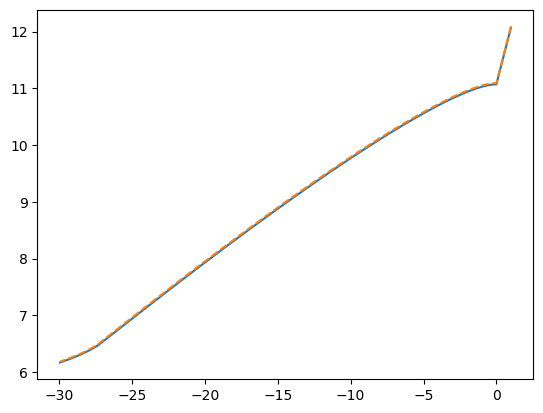

In [7]:
step = -0.05
gwl = np.arange(1, -30, step)
z = deep_zs[0]
pF = deep_pFs[0]

###
dz = abs(z)
dz[1:] = z[:-1] - z[1:] # profile depths into profile thicknesses

# finer grid for calculating wsto to avoid discontinuity in C (dWsto/dGWL)
z_fine = (np.arange(0, min(z), + step) + step).astype(np.float64)
dz_fine = z_fine * 0.0 - step
z_mid_fine = dz_fine / 2 - np.cumsum(dz_fine)
ix = np.zeros(len(z_fine), dtype=np.float64)

for depth in z:
    # below makes sure floating point precision doesnt mess with the ix
    ix += np.where((z_fine < depth) & ~np.isclose(z_fine, depth, atol=1e-9), 1, 0)

pF_fine={}
for key in pF.keys():
    pp = []
    for i in range(len(z_fine)):
        pp.append(pF[key][int(ix[i])])
    pF_fine.update({key: np.array(pp)})

Wsto_deep = [sum(h_to_cellmoist(pF_fine, g - z_mid_fine, dz_fine) * dz_fine)
            + max(0.0,g) for g in gwl]
plt.plot(gwl, Wsto_deep)

###

z = deep_zs[0:1]
pF = deep_pFs[0:1]
dz = abs(z)
dz[:,1:] = z[:,:-1] - z[:,1:]
z_min = np.nanmin(z, axis=1)
max_len = int(abs(np.nanmin(z_min)) / abs(step)) + 1
z_fine = np.tile(np.arange(0, step * max_len, step), (z.shape[0], 1)) + step
dz_fine = z_fine * 0.0 - step
z_mid_fine = dz_fine / 2 - np.cumsum(dz_fine, axis=1)
ix = np.full((z_fine.shape), np.nan)
# Expand z along the second axis to match z_fine's shape (broadcasting)
z_expanded = np.expand_dims(z, axis=1)  # Shape: (rows, 1, cols)
z_fine_expanded = np.expand_dims(z_fine, axis=2)  # Shape: (rows, fine_steps, 1)

# Compute mask using broadcasting (row-wise comparison)
mask = (z_fine_expanded < z_expanded) & ~np.isclose(z_fine_expanded, z_expanded, atol=1e-9)

# Sum along the depth dimension to count how many times z_fine falls below z
ix = np.sum(mask, axis=2).astype(int)
#ix = np.nan_to_num(ix, nan=0).astype(int)

#plt.plot(ix[0])
pF_fine = {}

for key in pF[0].keys():  # Iterate over each parameter in `pF`
    # Convert pF into an array ensuring consistent shapes
    try:
        pF_array = np.vstack([p[key] for p in pF])  # Ensures (rows, depths) shape
    except ValueError:  # If rows have different lengths, handle it gracefully
        max_depth = max(len(p[key]) for p in pF)  # Find the longest row
        pF_array = np.full((len(pF), max_depth), np.nan)  # Initialize padded array

        # Fill rows with actual values
        for i, p in enumerate(pF):
            pF_array[i, :len(p[key])] = p[key]

    # Ensure `ix` values are within valid range (clip to prevent indexing errors)
    ix_valid = np.clip(ix.astype(int), 0, pF_array.shape[1] - 1)

    # Assign values using vectorized indexing
    pF_fine[key] = np.take_along_axis(pF_array, ix_valid, axis=1)  # Shape: (rows, fine_steps)


Wsto_deep = np.stack([h_to_cellmoist_vectorized(pF_fine, g - z_mid_fine, dz_fine) + max(0.0, g) for g in gwl]).T

plt.plot(gwl, Wsto_deep[0], linestyle='--')

In [48]:
print(deep_zs[0:1])

z = deep_zs[0]
pF = deep_pFs[0]

if z.ndim == 1:
    z = np.expand_dims(z, axis=0)
    pF = np.expand_dims(pF, axis=0)
    #if Ksat is not None:
    #    Ksat = np.expand_dims(Ksat, axis=0)
print(z)

[[ -1.2  -3.8  -4.   -5.4 -28. ]]
[[ -1.2  -3.8  -4.   -5.4 -28. ]]


In [111]:
z = deep_zs[id]
min(z)

-26.0

### WITH NEW GRID

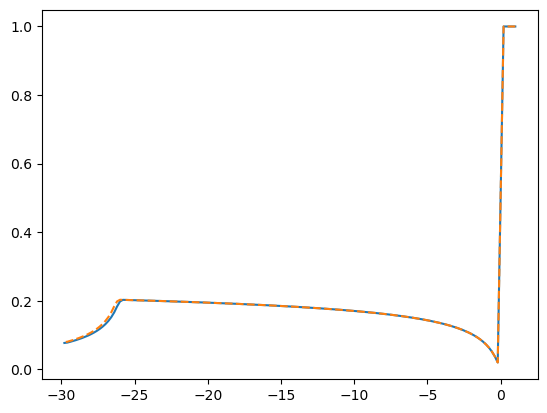

In [120]:
id = 15

step = -0.2
gwl = np.arange(1, -30, step)
z = deep_zs[id]
pF = deep_pFs[id]

###
dz = abs(z)
dz[1:] = z[:-1] - z[1:] # profile depths into profile thicknesses

# finer grid for calculating wsto to avoid discontinuity in C (dWsto/dGWL)
z_fine = (np.arange(0, min(z), + step) + step).astype(np.float64)
dz_fine = z_fine * 0.0 - step
z_mid_fine = dz_fine / 2 - np.cumsum(dz_fine)
ix = np.zeros(len(z_fine), dtype=np.float64)
for depth in z:
    # below makes sure floating point precision doesnt mess with the ix
    ix += np.where((z_fine < depth) & ~np.isclose(z_fine, depth, atol=1e-9), 1, 0)

pF_fine={}
for key in pF.keys():
    pp = []
    for i in range(len(z_fine)):
        pp.append(pF[key][int(ix[i])])
    pF_fine.update({key: np.array(pp)})
Wsto_deep = [sum(h_to_cellmoist(pF_fine, g - z_mid_fine, dz_fine) * dz_fine)
            + max(0.0,g) for g in gwl]
plt.figure(1)
plt.plot(np.array(gwl), np.array(np.gradient(Wsto_deep)/np.gradient(gwl)))
#plt.figure(2)
#plt.plot(gwl, Wsto_deep)

###

z = deep_zs[id]
pF = deep_pFs[id]

if z.ndim == 1:
    z = np.expand_dims(z, axis=0)
    pF = np.expand_dims(pF, axis=0)
    #if Ksat is not None:
    #    Ksat = np.expand_dims(Ksat, axis=0)

dz = np.abs(z)
dz = np.hstack((dz[:, :1], np.diff(dz, axis=1)))
changing_lim = False

if changing_lim == False:
    step = -0.2
    z_min = np.nanmin(z, axis=1)
    max_len = int(abs(np.nanmin(z_min)) / abs(step)) + 1
    z_fine = np.tile(np.arange(0, step * max_len, step), (z.shape[0], 1)) + step
    dz_fine = z_fine*0.0 - step
    z_mid_fine = dz_fine / 2 - np.cumsum(dz_fine, axis=1)
    ix = np.full((z_fine.shape), np.nan)
    # Expand z along the second axis to match z_fine's shape (broadcasting)
    z_expanded = np.expand_dims(z, axis=1)  # Shape: (rows, 1, cols)
    z_fine_expanded = np.expand_dims(z_fine, axis=2)  # Shape: (rows, fine_steps, 1)


elif changing_lim == True:
    z_min = np.nanmin(z, axis=1)
    z_min_min = np.nanmin(z_min)
    # First segment: 0m to -1m (step = 0.05m)
    step1 = -0.05
    z1 = np.arange(0+step1, -1.0+step1, step1)
    # Second segment: -1m to -5m (step = 0.20m)
    step2 = -0.20
    z2 = np.arange(-1.0+step1, -5.0+step2, step2)
    # Third segment: -5m to z_min (step = 10.)
    step3 = -1.0
    z3 = np.arange(-5.05+step2, z_min_min + step3 + step3, step3)  # Ensure we reach z_min
    # Combine all segments
    z_values = np.concatenate([z1, z2, z3])  # Ensure exact z_min
    z_fine = np.tile(z_values, (z.shape[0], 1)) #+ step3
    # Compute dz_fine
    dz_fine = np.abs(np.diff(z_fine, axis=1))  # Compute differences along the second axis
    # Insert the first element (z_fine[:, 0] - 0) at the beginning
    dz_fine = np.hstack([z_fine[:, [0]], dz_fine])
    z_mid_fine = dz_fine / 2 - np.cumsum(dz_fine, axis=1)
    ix = np.full((z_fine.shape), np.nan)
    # Expand z along the second axis to match z_fine's shape (broadcasting)
    z_expanded = np.expand_dims(z, axis=1)  # Shape: (rows, 1, cols)
    z_fine_expanded = np.expand_dims(z_fine, axis=2)  # Shape: (rows, fine_steps, 1)

    if changing_lim == False:
        gwl = np.arange(1.0, min(z_min)-5, step)
    elif changing_lim == True:
        # First segment: 1m to 0m (step = 1.0m)
        step1 = -0.05
        z1 = np.arange(1, 0.0, step1)
        # Second segment: -1m to -5m (step = 0.05m)
        step2 = -0.05
        z2 = np.arange(0.0, -1.0, step2)
        # Third segment: -5m to z_min (step = 0.2)
        step3 = -0.2
        z3 = np.arange(-1.0, -5.0, step2)
        # Fourth segment: -5m to z_min (step = 1.0)
        step4 = -1.0
        z4 = np.arange(-5.0, z_min_min -5, step4)  # Ensure we reach z_min
        gwl = np.concatenate([z1, z2, z3, z4])  # Ensure exact z_min

# Compute mask using broadcasting (row-wise comparison)
mask = (z_fine_expanded < z_expanded) & ~np.isclose(z_fine_expanded, z_expanded, atol=1e-9)

# Sum along the depth dimension to count how many times z_fine falls below z
ix = np.sum(mask, axis=2).astype(int)
#ix = np.nan_to_num(ix, nan=0).astype(int)

#plt.plot(ix[0])
pF_fine = {}

for key in pF[0].keys():  # Iterate over each parameter in `pF`
    # Convert pF into an array ensuring consistent shapes
    try:
        pF_array = np.vstack([p[key] for p in pF])  # Ensures (rows, depths) shape
    except ValueError:  # If rows have different lengths, handle it gracefully
        max_depth = max(len(p[key]) for p in pF)  # Find the longest row
        pF_array = np.full((len(pF), max_depth), np.nan)  # Initialize padded array

        # Fill rows with actual values
        for i, p in enumerate(pF):
            pF_array[i, :len(p[key])] = p[key]

    # Ensure `ix` values are within valid range (clip to prevent indexing errors)
    ix_valid = np.clip(ix.astype(int), 0, pF_array.shape[1] - 1)

    # Assign values using vectorized indexing
    pF_fine[key] = np.take_along_axis(pF_array, ix_valid, axis=1)  # Shape: (rows, fine_steps)

Wsto_deep = np.stack([h_to_cellmoist_vectorized(pF_fine, g - z_mid_fine, dz_fine) + np.maximum(0.0, g) for g in gwl]).T

plt.plot(np.array(gwl), np.array(np.gradient(Wsto_deep[0])/np.gradient(gwl)), linestyle='--')
#plt.figure(4)
#plt.plot(gwl, Wsto_deep[0], linestyle='--')

### CPROFILER FOR H_TO_CELLMOIST

In [41]:
step = -0.05
gwl = np.arange(1, -30, step)
#gwl = np.array([1.])
z = deep_zs[0]
pF = deep_pFs[0]

###
dz = abs(z)
dz[1:] = z[:-1] - z[1:] # profile depths into profile thicknesses

# finer grid for calculating wsto to avoid discontinuity in C (dWsto/dGWL)
z_fine = (np.arange(0, min(z), + step) + step).astype(np.float64)
dz_fine = z_fine * 0.0 - step
z_mid_fine = dz_fine / 2 - np.cumsum(dz_fine)
ix = np.zeros(len(z_fine), dtype=np.float64)

for depth in z:
    # below makes sure floating point precision doesnt mess with the ix
    ix += np.where((z_fine < depth) & ~np.isclose(z_fine, depth, atol=1e-9), 1, 0)

pF_fine={}
for key in pF.keys():
    pp = []
    for i in range(len(z_fine)):
        pp.append(pF[key][int(ix[i])])
    pF_fine.update({key: np.array(pp)})

cProfile.run('[sum(h_to_cellmoist(pF_fine, g - z_mid_fine, dz_fine) * dz_fine)+ max(0.0,g) for g in gwl]')

         7444 function calls in 0.041 seconds

   Ordered by: standard name

   ncalls  tottime  percall  cumtime  percall filename:lineno(function)
      620    0.020    0.000    0.025    0.000 3884114.py:74(h_to_cellmoist)
        1    0.002    0.002    0.041    0.041 <string>:1(<listcomp>)
        1    0.000    0.000    0.041    0.041 <string>:1(<module>)
      620    0.000    0.000    0.000    0.000 multiarray.py:346(where)
     1860    0.001    0.000    0.001    0.000 {built-in method builtins.abs}
        1    0.000    0.000    0.041    0.041 {built-in method builtins.exec}
      620    0.000    0.000    0.000    0.000 {built-in method builtins.len}
      620    0.000    0.000    0.000    0.000 {built-in method builtins.max}
      620    0.014    0.000    0.014    0.000 {built-in method builtins.sum}
     2480    0.004    0.000    0.004    0.000 {built-in method numpy.array}
        1    0.000    0.000    0.000    0.000 {method 'disable' of '_lsprof.Profiler' objects}




In [42]:

z = deep_zs
pF = deep_pFs
dz = abs(z)
dz[:,1:] = z[:,:-1] - z[:,1:]
z_min = np.nanmin(z, axis=1)
max_len = int(abs(np.nanmin(z_min)) / abs(step)) + 1
z_fine = np.tile(np.arange(0, step * max_len, step), (z.shape[0], 1)) + step
dz_fine = z_fine * 0.0 - step
z_mid_fine = dz_fine / 2 - np.cumsum(dz_fine, axis=1)
ix = np.full((z_fine.shape), np.nan)
# Expand z along the second axis to match z_fine's shape (broadcasting)
z_expanded = np.expand_dims(z, axis=1)  # Shape: (rows, 1, cols)
z_fine_expanded = np.expand_dims(z_fine, axis=2)  # Shape: (rows, fine_steps, 1)

# Compute mask using broadcasting (row-wise comparison)
mask = (z_fine_expanded < z_expanded) & ~np.isclose(z_fine_expanded, z_expanded, atol=1e-9)

# Sum along the depth dimension to count how many times z_fine falls below z
ix = np.sum(mask, axis=2).astype(int)
ix = np.nan_to_num(ix, nan=0).astype(int)

#plt.plot(ix[0])
pF_fine = {}

for key in pF[0].keys():  # Iterate over each parameter in `pF`
    # Convert pF into an array ensuring consistent shapes
    try:
        pF_array = np.vstack([p[key] for p in pF])  # Ensures (rows, depths) shape
    except ValueError:  # If rows have different lengths, handle it gracefully
        max_depth = max(len(p[key]) for p in pF)  # Find the longest row
        pF_array = np.full((len(pF), max_depth), np.nan)  # Initialize padded array

        # Fill rows with actual values
        for i, p in enumerate(pF):
            pF_array[i, :len(p[key])] = p[key]

    # Ensure `ix` values are within valid range (clip to prevent indexing errors)
    ix_valid = np.clip(ix.astype(int), 0, pF_array.shape[1] - 1)

    # Assign values using vectorized indexing
    pF_fine[key] = np.take_along_axis(pF_array, ix_valid, axis=1)  # Shape: (rows, fine_steps)


cProfile.run('np.stack([h_to_cellmoist_vectorized(pF_fine, g - z_mid_fine, dz_fine) + max(0.0, g) for g in gwl]).T')

         15514 function calls in 0.703 seconds

   Ordered by: standard name

   ncalls  tottime  percall  cumtime  percall filename:lineno(function)
      620    0.614    0.001    0.692    0.001 60307834.py:91(h_to_cellmoist_vectorized)
        1    0.011    0.011    0.703    0.703 <string>:1(<listcomp>)
        1    0.000    0.000    0.703    0.703 <string>:1(<module>)
      620    0.000    0.000    0.000    0.000 fromnumeric.py:2172(_sum_dispatcher)
      620    0.000    0.000    0.009    0.000 fromnumeric.py:2177(sum)
      620    0.000    0.000    0.009    0.000 fromnumeric.py:71(_wrapreduction)
      620    0.000    0.000    0.000    0.000 fromnumeric.py:72(<dictcomp>)
      620    0.000    0.000    0.000    0.000 multiarray.py:1080(copyto)
        1    0.000    0.000    0.000    0.000 multiarray.py:153(concatenate)
      620    0.000    0.000    0.000    0.000 multiarray.py:346(where)
      620    0.000    0.000    0.000    0.000 nanfunctions.py:618(_nansum_dispatcher)
      620

In [43]:

z = deep_zs
pF = deep_pFs
dz = abs(z)
dz[:,1:] = z[:,:-1] - z[:,1:]
z_min = np.nanmin(z, axis=1)
max_len = int(abs(np.nanmin(z_min)) / abs(step)) + 1
z_fine = np.tile(np.arange(0, step * max_len, step), (z.shape[0], 1)) + step
dz_fine = z_fine * 0.0 - step
z_mid_fine = dz_fine / 2 - np.cumsum(dz_fine, axis=1)
ix = np.full((z_fine.shape), np.nan)
# Expand z along the second axis to match z_fine's shape (broadcasting)
z_expanded = np.expand_dims(z, axis=1)  # Shape: (rows, 1, cols)
z_fine_expanded = np.expand_dims(z_fine, axis=2)  # Shape: (rows, fine_steps, 1)

# Compute mask using broadcasting (row-wise comparison)
mask = (z_fine_expanded < z_expanded) & ~np.isclose(z_fine_expanded, z_expanded, atol=1e-9)

# Sum along the depth dimension to count how many times z_fine falls below z
ix = np.sum(mask, axis=2).astype(int)
ix = np.nan_to_num(ix, nan=0).astype(int)

#plt.plot(ix[0])
pF_fine = {}

for key in pF[0].keys():  # Iterate over each parameter in `pF`
    # Convert pF into an array ensuring consistent shapes
    try:
        pF_array = np.vstack([p[key] for p in pF])  # Ensures (rows, depths) shape
    except ValueError:  # If rows have different lengths, handle it gracefully
        max_depth = max(len(p[key]) for p in pF)  # Find the longest row
        pF_array = np.full((len(pF), max_depth), np.nan)  # Initialize padded array

        # Fill rows with actual values
        for i, p in enumerate(pF):
            pF_array[i, :len(p[key])] = p[key]

    # Ensure `ix` values are within valid range (clip to prevent indexing errors)
    ix_valid = np.clip(ix.astype(int), 0, pF_array.shape[1] - 1)

    # Assign values using vectorized indexing
    pF_fine[key] = np.take_along_axis(pF_array, ix_valid, axis=1)  # Shape: (rows, fine_steps)


cProfile.run('h_to_cellmoist_vectorized_2(pF_fine, gwl, z_mid_fine, dz_fine) + np.maximum(0.0, gwl)')

         13 function calls in 1.609 seconds

   Ordered by: standard name

   ncalls  tottime  percall  cumtime  percall filename:lineno(function)
        1    1.578    1.578    1.586    1.586 2588371446.py:93(h_to_cellmoist_vectorized_2)
        1    0.023    0.023    1.609    1.609 <string>:1(<module>)
        1    0.000    0.000    0.007    0.007 _methods.py:47(_sum)
        1    0.000    0.000    0.000    0.000 fromnumeric.py:2317(_any_dispatcher)
        1    0.000    0.000    0.001    0.001 fromnumeric.py:2322(any)
        1    0.000    0.000    0.001    0.001 fromnumeric.py:71(_wrapreduction)
        1    0.000    0.000    0.000    0.000 fromnumeric.py:72(<dictcomp>)
        1    0.000    0.000    1.609    1.609 {built-in method builtins.exec}
        1    0.000    0.000    0.000    0.000 {method 'disable' of '_lsprof.Profiler' objects}
        1    0.000    0.000    0.000    0.000 {method 'items' of 'dict' objects}
        2    0.008    0.004    0.008    0.004 {method 'reduce' 

### TESTING TRANSMISSIVITY SEPARATELY

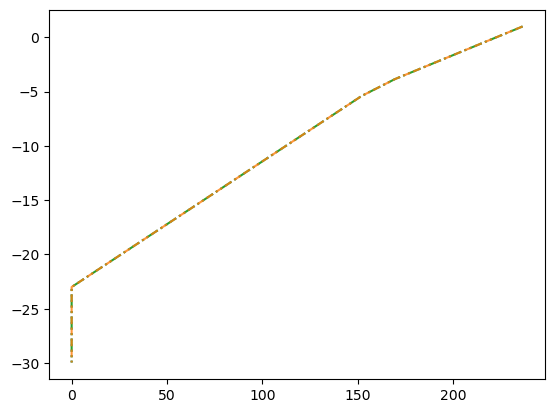

In [68]:
gwl = np.arange(1, -30, -0.05)
#gwl = np.array([-30])
z = deep_zs[0]
dz = abs(z)
dz[1:] = z[:-1] - z[1:] # profile depths into profile thicknesses
Tr0 = [transmissivity(dz, deep_ksats[0], g) * 86400. for g in gwl]  # [m2 d-1]
plt.figure(1)
plt.plot(Tr0, gwl, alpha=0.7, linestyle=':', color='tab:blue')

#gwl = np.arange(1, -30, -0.05).reshape(1, -1)
z = deep_zs
dz = abs(z)
dz = np.hstack((dz[:, :1], np.diff(dz, axis=1)))

Tr1 = np.stack([transmissivity_vectorized(dz, deep_ksats, g) * 86400. for g in gwl]).T
plt.plot(Tr1[0], gwl, linestyle='-.', color='tab:green', alpha=1.0)

z = deep_zs
dz = abs(z)
dz = np.hstack((dz[:, :1], np.diff(dz, axis=1)))

Tr1 = transmissivity_vectorized_2(dz, deep_ksats, gwl) * 86400  # Shape: (n_cells, n_gwl)
plt.plot(Tr1[0], gwl, linestyle='--', color='tab:orange', alpha=0.8)

### CPROFILER

In [45]:
gwl = np.arange(1, -30, -0.05)
#gwl = np.array([-30])
z = deep_zs[0]
dz = abs(z)
dz[1:] = z[:-1] - z[1:] # profile depths into profile thicknesses
cProfile.run('[transmissivity(dz, deep_ksats[0], g) * 86400. for g in gwl]')  # [m2 d-1]

         36244 function calls in 0.035 seconds

   Ordered by: standard name

   ncalls  tottime  percall  cumtime  percall filename:lineno(function)
      620    0.012    0.000    0.035    0.000 3884114.py:118(transmissivity)
        1    0.000    0.000    0.035    0.035 <string>:1(<listcomp>)
        1    0.000    0.000    0.035    0.035 <string>:1(<module>)
     2200    0.001    0.000    0.001    0.000 arraysetops.py:125(_unpack_tuple)
     2200    0.000    0.000    0.000    0.000 arraysetops.py:133(_unique_dispatcher)
     2200    0.001    0.000    0.012    0.000 arraysetops.py:138(unique)
     2200    0.007    0.000    0.010    0.000 arraysetops.py:323(_unique1d)
     1100    0.000    0.000    0.000    0.000 arraysetops.py:368(_intersect1d_dispatcher)
     1100    0.005    0.000    0.020    0.000 arraysetops.py:373(intersect1d)
      620    0.000    0.000    0.000    0.000 fromnumeric.py:2508(_cumsum_dispatcher)
      620    0.000    0.000    0.001    0.000 fromnumeric.py:2512(cum

In [47]:
z = deep_zs
dz = abs(z)
dz = np.hstack((dz[:, :1], np.diff(dz, axis=1)))

cProfile.run('np.stack([transmissivity_vectorized(dz, deep_ksats, g) * 86400. for g in gwl]).T')

         21094 function calls in 0.038 seconds

   Ordered by: standard name

   ncalls  tottime  percall  cumtime  percall filename:lineno(function)
      620    0.025    0.000    0.036    0.000 60307834.py:139(transmissivity_vectorized)
        1    0.001    0.001    0.037    0.037 <string>:1(<listcomp>)
        1    0.000    0.000    0.038    0.038 <string>:1(<module>)
      620    0.000    0.000    0.000    0.000 fromnumeric.py:1136(_argmax_dispatcher)
      620    0.000    0.000    0.002    0.000 fromnumeric.py:1140(argmax)
     1240    0.000    0.000    0.000    0.000 fromnumeric.py:2172(_sum_dispatcher)
     1240    0.001    0.000    0.005    0.000 fromnumeric.py:2177(sum)
      620    0.000    0.000    0.000    0.000 fromnumeric.py:2317(_any_dispatcher)
      620    0.000    0.000    0.002    0.000 fromnumeric.py:2322(any)
      620    0.000    0.000    0.000    0.000 fromnumeric.py:2508(_cumsum_dispatcher)
      620    0.000    0.000    0.002    0.000 fromnumeric.py:2512(cumsu

In [48]:
z = deep_zs
dz = abs(z)
dz = np.hstack((dz[:, :1], np.diff(dz, axis=1)))
cProfile.run('transmissivity_vectorized_2(dz, deep_ksats, gwl)')

         36 function calls in 0.008 seconds

   Ordered by: standard name

   ncalls  tottime  percall  cumtime  percall filename:lineno(function)
        1    0.005    0.005    0.007    0.007 2588371446.py:149(transmissivity_vectorized_2)
        1    0.000    0.000    0.007    0.007 <string>:1(<module>)
        1    0.000    0.000    0.000    0.000 fromnumeric.py:1136(_argmax_dispatcher)
        1    0.000    0.000    0.001    0.001 fromnumeric.py:1140(argmax)
        2    0.000    0.000    0.000    0.000 fromnumeric.py:2172(_sum_dispatcher)
        2    0.000    0.000    0.001    0.000 fromnumeric.py:2177(sum)
        1    0.000    0.000    0.000    0.000 fromnumeric.py:2317(_any_dispatcher)
        1    0.000    0.000    0.001    0.001 fromnumeric.py:2322(any)
        1    0.000    0.000    0.000    0.000 fromnumeric.py:2508(_cumsum_dispatcher)
        1    0.000    0.000    0.000    0.000 fromnumeric.py:2512(cumsum)
        2    0.000    0.000    0.001    0.000 fromnumeric.py:53(_

{'to_gwl': <scipy.interpolate._interpolate.interp1d at 0x4aa8fc870>,
 'to_wsto': <scipy.interpolate._interpolate.interp1d at 0x3d9787fc0>,
 'to_C': <scipy.interpolate._interpolate.interp1d at 0x3c9e2ae40>,
 'to_Tr': <scipy.interpolate._interpolate.interp1d at 0x162852da0>}

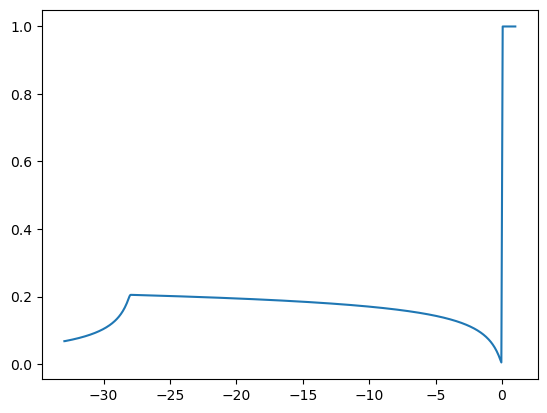

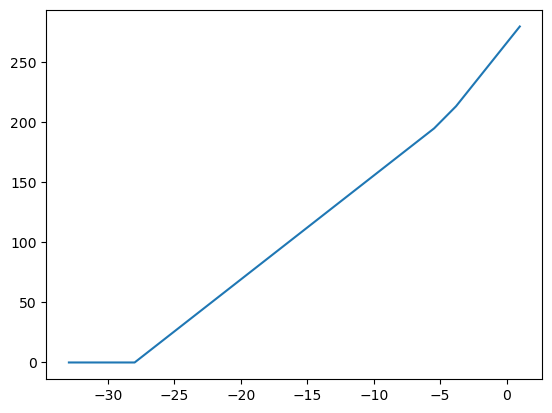

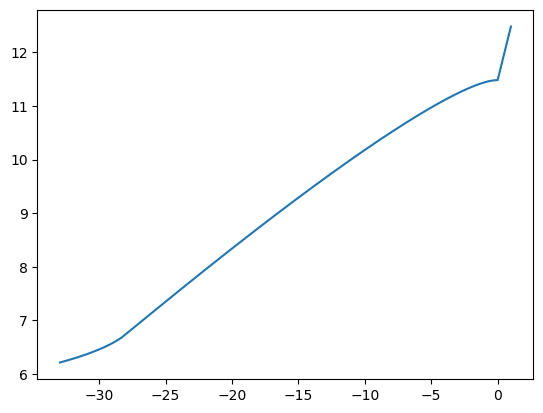

In [122]:
gwl_Wsto(deep_zs[0], deep_pFs[0], deep_ksats[0])

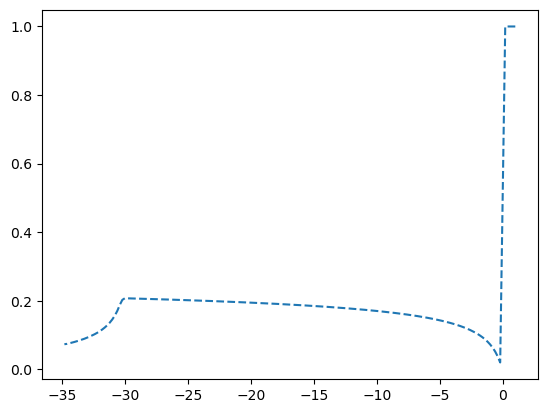

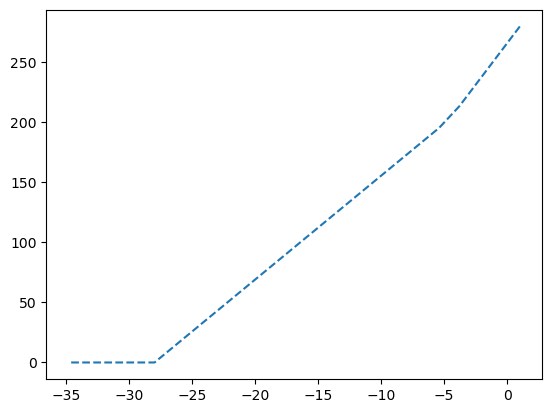

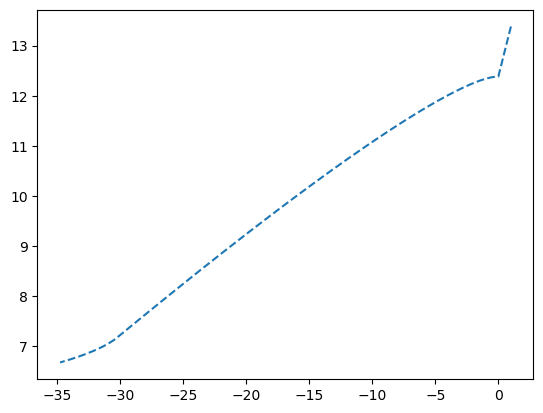

In [121]:
#ifs = gwl_Wsto(deep_zs[0], deep_pFs[0], deep_ksats[0])
ifs_v = gwl_Wsto_vectorized(deep_zs, deep_pFs, deep_ksats)

#### DEMONSTATING HOW LONG SIMULATION WOULD TAKE

In [7]:
to_wsto = np.array(ifs_v['to_wsto'])
vectorized_interp = np.vectorize(lambda f, x: f(x))
test = np.random.uniform(-10, -1, size=len(to_wsto))
result = np.full(len(test), np.nan)

In [8]:
for i in range(365):
    result = vectorized_interp(to_wsto, test)

KeyboardInterrupt: 

In [8]:
for i in range(365):
    for j in range(len(to_wsto)):
        result[j] = to_wsto[j](test[j])

### BELOW IS WITH FOR LOOP

In [14]:
for i in range(len(deep_id_f)):
    if isinstance(deep_pFs[i], dict):  # Ensure it's valid before calling gwl_Wsto
        deep_ifs[i] = gwl_Wsto(deep_zs[i], deep_pFs[i], deep_ksats[i])
        deep_ifs_root[i] = gwl_Wsto(deep_zs[i][:2], 
                                    {k: deep_pFs[i][k][:2] for k in deep_pFs[i]}, 
                                    root=True)

        wtso_to_gwl[i] = deep_ifs[i]['to_gwl']
        gwl_to_wsto[i] = deep_ifs[i]['to_wsto']
        gwl_to_C[i] = deep_ifs[i]['to_C']
        gwl_to_Tr[i] = deep_ifs[i]['to_Tr']
        gwl_to_rootmoist[i] = deep_ifs_root[i]['to_rootmoist']

wtso_to_gwl = wtso_to_gwl.reshape(deep_id.shape)
gwl_to_wsto = gwl_to_wsto.reshape(deep_id.shape)
gwl_to_C = gwl_to_C.reshape(deep_id.shape)
gwl_to_Tr = gwl_to_Tr.reshape(deep_id.shape)
gwl_to_rootmoist = gwl_to_rootmoist.reshape(deep_id.shape)

In [14]:
cProfile.run('gwl_Wsto_vectorized(deep_zs, deep_pFs, deep_ksats)')

         71783 function calls in 0.871 seconds

   Ordered by: standard name

   ncalls  tottime  percall  cumtime  percall filename:lineno(function)
        1    0.002    0.002    0.871    0.871 60307834.py:1(gwl_Wsto_vectorized)
      720    0.019    0.000    0.029    0.000 60307834.py:139(transmissivity_vectorized)
        4    0.000    0.000    0.000    0.000 60307834.py:46(<listcomp>)
        1    0.017    0.017    0.820    0.820 60307834.py:64(<listcomp>)
        1    0.001    0.001    0.030    0.030 60307834.py:73(<listcomp>)
        1    0.000    0.000    0.002    0.002 60307834.py:76(<listcomp>)
        1    0.000    0.000    0.002    0.002 60307834.py:77(<listcomp>)
        1    0.000    0.000    0.004    0.004 60307834.py:78(<listcomp>)
        1    0.000    0.000    0.002    0.002 60307834.py:79(<listcomp>)
      720    0.716    0.001    0.803    0.001 60307834.py:91(h_to_cellmoist_vectorized)
        1    0.000    0.000    0.871    0.871 <string>:1(<module>)
      800    0

##### BELOW TESTING NEW AND OLD FUNCTIONS, INSIDE LOOPS AS USED IN IOTOOLS! DIFFERENCES IN WSTO(GWL) DUE TO DIFFERENT DISCRETIZATION: NEW FUNCTION CALCULATES THE GRID SIMILARLY FOR EACH SOILTYPE WHILE OLD CALCULATES Z_MIN FOR EACH SOILTYPE

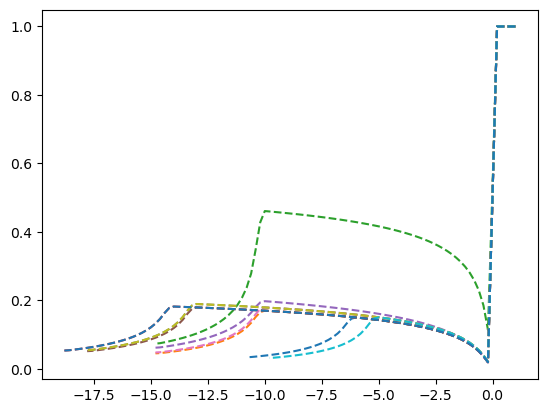

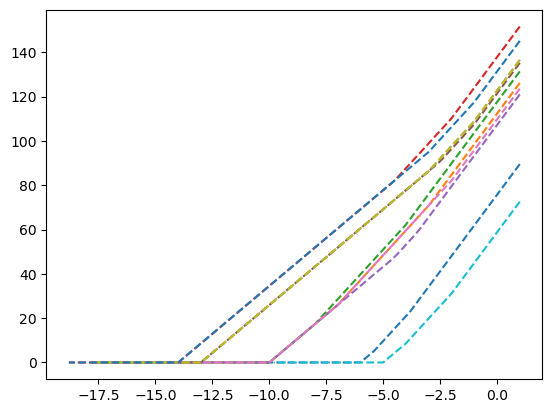

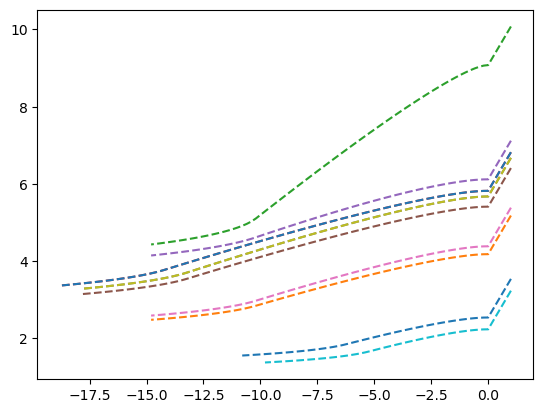

In [123]:
from iotools import read_AsciiGrid
file = r'/Users/jpnousu/SpaFHy_RUNS/krycklan/gis/25m_0case/soil.asc'
soil = read_AsciiGrid(file)[0]
data = {}
data['deep_id'] = soil
data.update({'soiltype': np.empty(np.shape(data['deep_id']),dtype=object)})

for key, value in deepp.items():
    c = value['deep_id']
    ix = np.where(data['deep_id'] == c)
    data['soiltype'][ix] = key
    # interpolation function between wsto and gwl
    value.update(gwl_Wsto_vectorized(value['deep_z'], value['pF'], value['deep_ksat']))
    # interpolation function between root_wsto and gwl
    value.update(gwl_Wsto_vectorized(value['deep_z'][:2], {key: value['pF'][key][:2] for key in value['pF'].keys()}, root=True))

data['wtso_to_gwl'] = {soiltype: deepp[soiltype]['to_gwl'] for soiltype in deepp.keys()}


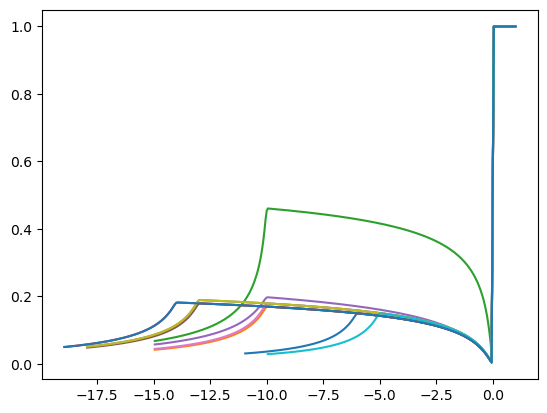

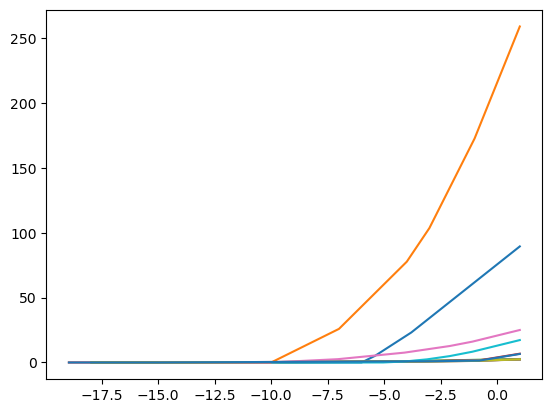

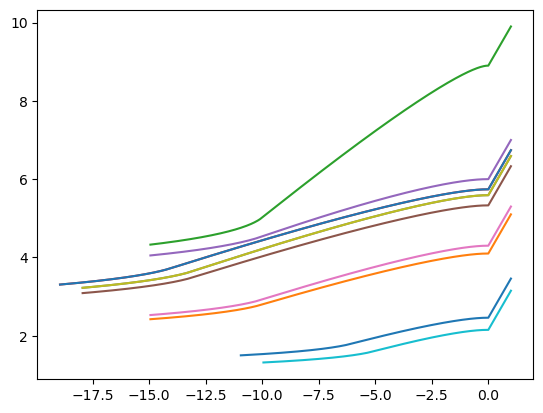

In [124]:
from iotools import read_AsciiGrid
file = r'/Users/jpnousu/SpaFHy_RUNS/krycklan/gis/25m_0case/soil.asc'
soil = read_AsciiGrid(file)[0]
data = {}
data['deep_id'] = soil
data.update({'soiltype': np.empty(np.shape(data['deep_id']),dtype=object)})

for key, value in deepp.items():
    c = value['deep_id']
    ix = np.where(data['deep_id'] == c)
    data['soiltype'][ix] = key
    # interpolation function between wsto and gwl
    value.update(gwl_Wsto(value['deep_z'], value['pF'], value['deep_ksat']))
    # interpolation function between root_wsto and gwl
    value.update(gwl_Wsto(value['deep_z'][:2], {key: value['pF'][key][:2] for key in value['pF'].keys()}, root=True))

data['wtso_to_gwl'] = {soiltype: deepp[soiltype]['to_gwl'] for soiltype in deepp.keys()}

In [65]:
data['wtso_to_gwl']

{'Postglacial_sand': <scipy.interpolate._interpolate.interp1d at 0x37f6590e0>,
 'Glaciofluvial_sediment': <scipy.interpolate._interpolate.interp1d at 0x104e068a0>,
 'Peat': <scipy.interpolate._interpolate.interp1d at 0x37f4dd9a0>,
 'Postglacial_sand_gravel': <scipy.interpolate._interpolate.interp1d at 0x37f581d10>,
 'Clay_silt': <scipy.interpolate._interpolate.interp1d at 0x37f65a210>,
 'Washed_sediment_gravel_boulders': <scipy.interpolate._interpolate.interp1d at 0x37f59a260>,
 'Water': <scipy.interpolate._interpolate.interp1d at 0x108ca1c70>,
 'Moraine': <scipy.interpolate._interpolate.interp1d at 0x37f5ae530>,
 'Fill': <scipy.interpolate._interpolate.interp1d at 0x37f5ae490>,
 'Bedrock': <scipy.interpolate._interpolate.interp1d at 0x37f77e8a0>,
 'Fluvial_sediment_sand': <scipy.interpolate._interpolate.interp1d at 0x37f6d9220>}

In [66]:
to_wsto

array([<scipy.interpolate._interpolate.interp1d object at 0x36b19b890>,
       ...,
      dtype=object)